In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sc_stats
import tabulate

In [2]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  'font.size': 12,
  'grid.alpha': 0.25})

## Function declarations

### Read `ods` to `DataFrame`


In [3]:
def read_ods(filename, columns=None):
  if columns is None:
    df = pd.read_excel(filename, engine="odf", header=0)
  else:
    key_arr = (k for k in columns.keys())
    df = pd.read_excel(filename, engine="odf", header=0,
                      usecols=columns)
    df = df.rename(columns=columns)
  return df

### Get linear regression coefficients ($b_0$ and $b_1$)

In [4]:
def get_regress_coeff(df):
  df["XY"] = df['X'] * df['Y']
  df["X^2"] = df['X']**2

  n = len(df)
  sumXY = df["XY"].sum()
  sumX = df["X"].sum()
  sumY = df["Y"].sum()
  sumXsq = df["X^2"].sum()

  b1 = (n*sumXY - sumX*sumY) / (n*sumXsq - sumX**2)
  b0 = sumY/n - b1*sumX/n

  # print(f"(b0, b1) = ({b0:.2f}, {b1:.2f})")
  return [b0, b1], df


## Load the data

In [5]:
filename = "05-table-01-milk-gallons.ods"

df = read_ods(filename)

df

,Week,"Weekly Sales Level, Y (1,000s of gallons)",Selling Price X ($)
0,1,10,1.3
1,2,6,2.0
2,3,5,1.7
3,4,12,1.5
4,5,10,1.6
5,6,15,1.2
6,7,5,1.6
7,8,12,1.4
8,9,17,1.0
9,10,20,1.1


## Compute least squares coefficients ($b_1$ and $b_0$)

$$
\begin{gather*}
  b_1 = \frac{n \sum XY - \sum X \sum Y}{n \sum X^2 - (\sum X)^2} \\[12pt]
  b_0 = \frac{\sum Y}{n} - \frac{b_1 \sum X}{n}
\end{gather*}
$$

In [6]:
df_corr = df.copy()

# rename the corresponding X and Y column
df_corr = df_corr.rename(columns={
  "Weekly Sales Level, Y (1,000s of gallons)": 'Y',
  "Selling Price X ($)": 'X'})

[b0, b1], df_corr = get_regress_coeff(df_corr)

print(f"(b0, b1) = ({b0:.2f}, {b1:.2f})")
df_corr

(b0, b1) = (32.14, -14.54)


,Week,Y,X,XY,X^2
0,1,10,1.3,13.0,1.69
1,2,6,2.0,12.0,4.00
2,3,5,1.7,8.5,2.89
3,4,12,1.5,18.0,2.25
4,5,10,1.6,16.0,2.56
5,6,15,1.2,18.0,1.44
6,7,5,1.6,8.0,2.56
7,8,12,1.4,16.8,1.96
8,9,17,1.0,17.0,1.00
9,10,20,1.1,22.0,1.21


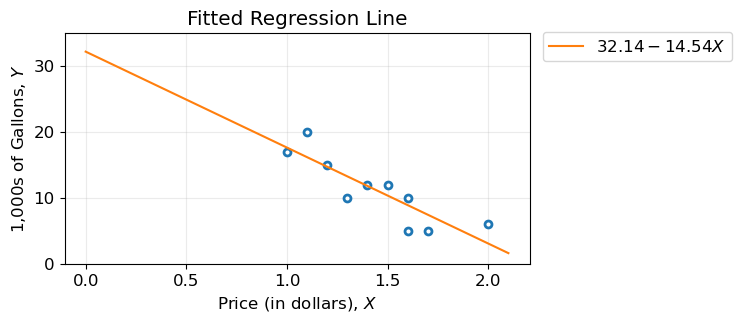

In [7]:
fig, ax = plt.subplots(figsize=(6, 3))


ax.plot(df_corr["X"], df_corr["Y"], 
  marker='o', markersize=5, markerfacecolor='white',
  linestyle='None', markeredgewidth=2) 

x_regress = np.linspace(0, 2.1)
ax.plot(x_regress, b0 + b1*x_regress, 
  linestyle='-',
  label=r"${:.2f}{:.2f}X$".format(b0, b1)) 

ax.set_ylim([0, 35])

ax.set_xlabel(r"Price (in dollars), $X$")
ax.set_ylabel(r"1,000s of Gallons, $Y$")
ax.set_title("Fitted Regression Line")

ax.legend(loc="upper left", bbox_to_anchor=[1.01, 1.04])
ax.grid("on")
plt.show(fig)

## Explained and unexplained variation

In [36]:
def annotate_point_pair(ax, text, xy_start, xy_end,
  xycoords='data', text_offset=6, arrowprops=None):
  """
  Annotates two points by connecting them with an arrow.
  The annotation text is placed near the center of the arrow.
  """

  if arrowprops is None:
    arrowprops = dict(arrowstyle="->")

  assert isinstance(text,str)

  xy_text = ((xy_start[0] + xy_end[0])/2. , (xy_start[1] + xy_end[1])/2.)
  arrow_vector = xy_end[0]-xy_start[0] + (xy_end[1] - xy_start[1]) * 1j
  arrow_angle = np.angle(arrow_vector)
  text_angle = arrow_angle - 0.5*np.pi

  ax.annotate(
    '', xy=xy_end, xycoords=xycoords,
    xytext=xy_start, textcoords=xycoords,
    arrowprops=arrowprops)

  label = ax.annotate(
    text, 
    xy=xy_text, 
    xycoords=xycoords,
    xytext=(text_offset * np.cos(text_angle), text_offset * np.sin(text_angle)), 
    textcoords='offset points')

  return label
  

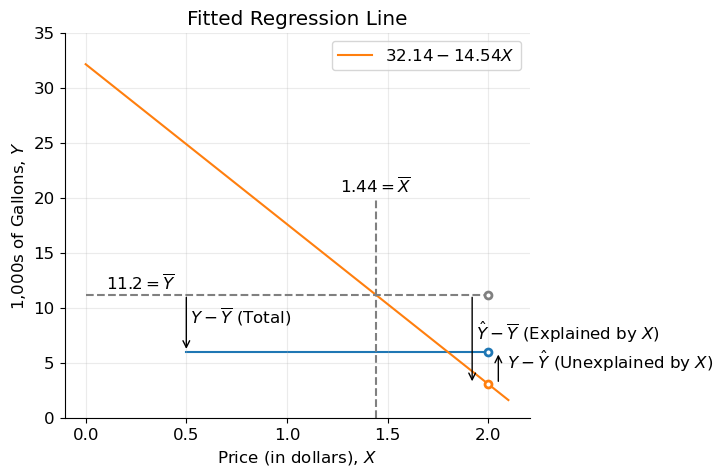

In [72]:
fig, ax = plt.subplots(figsize=(6, 5))

data_point_idx = 1
X_data = df_corr['X'].iloc[data_point_idx]
Y_data = df_corr['Y'].iloc[data_point_idx]
meanY = df_corr['Y'].mean()
data_point_hat_Y = b0 + b1*X_data

data_point_handler = ax.plot(X_data, Y_data,
  marker='o', markersize=5, markerfacecolor='white',
  linestyle='None', markeredgewidth=2) 
point_color = data_point_handler[0]._color
# line parallel to x-axis with y = data point y-coordinate. 
ax.plot([0.5, X_data], [Y_data, Y_data],
  linestyle='-', color=point_color, zorder=-99)
# distance arrow of (Y - meanY)
annotate_point_pair(ax, r'$Y - \overline{Y}$ (Total)', 
  [0.5, meanY], [0.5, Y_data], text_offset=-3)



x_regress = np.linspace(0, 2.1)
regress_line_handler = ax.plot(x_regress, b0 + b1*x_regress, 
  linestyle='-',
  label=r"${:.2f}{:.2f}X$".format(b0, b1)) 
line_color = regress_line_handler[0]._color
# forecast from regression
ax.plot( X_data, data_point_hat_Y,
  marker='o', markersize=5, markerfacecolor="white",
  color=line_color, linestyle="None", markeredgewidth=2)
# distance arrow of (Y - hat_Y)
X_offset = 0.05
annotate_point_pair(ax, r'$Y - \hat{Y}$ (Unexplained by $X$)', 
  [X_data+X_offset, data_point_hat_Y], [X_data+X_offset, Y_data], text_offset=6)


# forecast meanY
ax.plot(
  [0, df_corr['X'].iloc[data_point_idx]],
  [meanY, meanY], linestyle='--', color='grey')
ax.plot(
  df_corr['X'].iloc[data_point_idx], meanY,
  marker='o', markersize=5, markerfacecolor='white',
  color='grey',
  linestyle='None', markeredgewidth=2)
Y_offset = 0.5
ax.text(0.1, meanY + Y_offset, r"${:.1f} = $".format(meanY) + r"$\overline{Y}$")
# distance arrow of (hat_Y - meanY)
X_offset = 0.08
annotate_point_pair(ax, r'$\hat{Y} - \overline{Y}$ (Explained by $X$)', 
  [X_data-X_offset, meanY], [X_data-X_offset, data_point_hat_Y], text_offset=-3)


# mean of independent variable X
meanX = df_corr['X'].mean()
ax.plot(
  [meanX, meanX],
  [0, 20], linestyle='--', color='grey')
Y_offset = 0.5
ax.text(meanX, 20 + Y_offset, r"${:.2f} = $".format(meanX) + r"$\overline{X}$", 
  ha='center')


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_ylim([0, 35])

ax.set_xlabel(r"Price (in dollars), $X$")
ax.set_ylabel(r"1,000s of Gallons, $Y$")
ax.set_title("Fitted Regression Line")

# ax.legend(loc="upper left", bbox_to_anchor=[1.01, 1.04])
ax.legend(loc="best")
ax.grid("on")
plt.show(fig)
